In [29]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from collections import Counter

# maps
import geopandas as gpd
from geopandas import GeoDataFrame
import polyline
from shapely.geometry import Point, LineString, MultiLineString

# plot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

## Questions
- What is the average length (distance and time) of each taxi trip?
- How is this affected by different times of day.
- How many passengers are in each car on average?

In [3]:
taxi = pd.read_csv('data/yellow_tripdata_2018-06.csv')

In [4]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30
1,1,2018-06-01 00:04:18,2018-06-01 00:09:18,1,1.0,1,N,230,161,1,5.5,0.5,0.5,1.35,0.0,0.3,8.15
2,1,2018-06-01 00:14:39,2018-06-01 00:29:46,1,3.3,1,N,100,263,2,13.0,0.5,0.5,0.00,0.0,0.3,14.30
3,1,2018-06-01 00:51:25,2018-06-01 00:51:29,3,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
4,1,2018-06-01 00:55:06,2018-06-01 00:55:10,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80


In [5]:
taxi.shape

(8713831, 17)

In [14]:
print('Avg Trip Passengers: {}'.format(taxi['passenger_count'].mean()))
print('Avg Trip Distance: {}'.format(taxi['trip_distance'].mean()))

Avg Trip Passengers: 1.5975267365180712
Avg Trip Distance: 3.0084750117370853


In [20]:
taxi[['trip_distance','total_amount']].sort_values('trip_distance', ascending=False)

,trip_distance,total_amount
1532739,833.10,23.15
142767,606.00,31.55
4375539,222.96,0.31
3139184,142.00,216.32
5983592,139.16,373.30
4990020,129.21,58.56
742026,128.59,343.56
8392371,127.41,373.52
4307279,124.93,248.30
6271728,124.80,600.44


In [23]:
taxi = taxi.loc[(taxi['trip_distance']>0)&
                (taxi['trip_distance']<100)&
                (taxi['passenger_count']>0)]

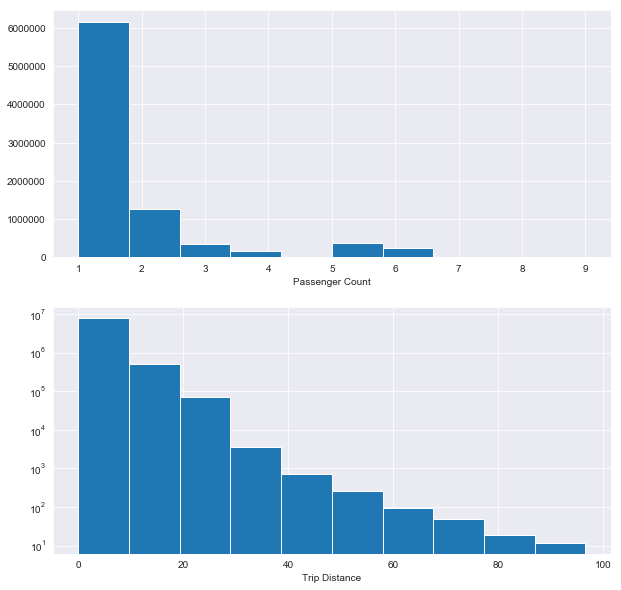

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.xlabel('Passenger Count')
plt.hist(taxi['passenger_count'],bins=10)
plt.subplot(2,1,2)
plt.xlabel('Trip Distance')
plt.hist(taxi['trip_distance'],bins=10)
plt.yscale('log')
plt.show()

In [28]:
taxi.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [30]:
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

In [40]:
taxi_626 = taxi.loc[(taxi['tpep_pickup_datetime']>'2018-6-26')&(taxi['tpep_pickup_datetime']<'2018-6-27')&
                    (taxi['tpep_dropoff_datetime']>'2018-6-26')&(taxi['tpep_dropoff_datetime']<'2018-6-27')]

taxi_626.sort_values('tpep_pickup_datetime')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
7267989,1,2018-06-26 00:00:01,2018-06-26 00:09:33,1,1.80,1,N,234,79,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80
7270645,2,2018-06-26 00:00:01,2018-06-26 00:06:44,2,2.14,1,N,186,229,1,8.0,0.5,0.5,1.08,0.0,0.3,10.38
7257924,2,2018-06-26 00:00:01,2018-06-26 00:18:15,4,7.19,1,N,162,80,1,22.5,0.5,0.5,5.95,0.0,0.3,29.75
7261724,2,2018-06-26 00:00:01,2018-06-26 00:09:33,5,2.13,1,N,65,195,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30
7271693,1,2018-06-26 00:00:01,2018-06-26 00:17:55,1,10.80,1,N,138,54,1,31.0,0.5,0.5,6.45,0.0,0.3,38.75
7262024,2,2018-06-26 00:00:02,2018-06-26 00:09:33,1,1.49,1,N,230,170,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80
7268049,2,2018-06-26 00:00:02,2018-06-26 00:10:54,1,2.37,1,N,239,230,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
7267889,2,2018-06-26 00:00:03,2018-06-26 00:11:24,3,2.03,1,N,230,68,1,10.0,0.5,0.5,2.26,0.0,0.3,13.56
7270924,1,2018-06-26 00:00:03,2018-06-26 00:05:36,1,1.40,1,N,237,43,1,7.0,0.5,0.5,2.00,0.0,0.3,10.30
7268871,1,2018-06-26 00:00:03,2018-06-26 00:29:40,1,9.60,1,N,68,243,2,32.0,0.5,0.5,0.00,0.0,0.3,33.30


In [31]:
taxi.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

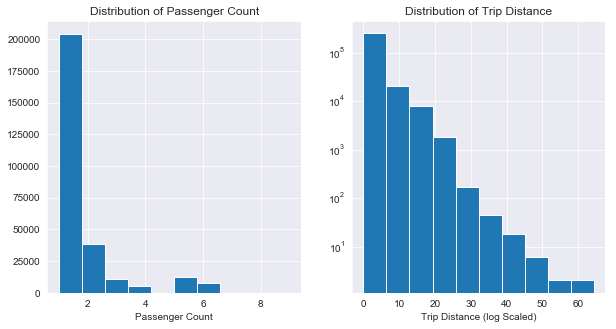

In [117]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Passenger Count')
plt.hist(taxi_626['passenger_count'])
plt.title('Distribution of Passenger Count')
plt.subplot(1,2,2)
plt.xlabel('Trip Distance (log Scaled)')
plt.hist(taxi_626['trip_distance'],bins=10)
plt.title('Distribution of Trip Distance')
plt.yscale('log')
plt.show()

In [43]:
taxi_model = taxi_626
taxi_model['tpep_pickup_datetime'] = pd.to_numeric(taxi_model['tpep_pickup_datetime'])
taxi_model['tpep_dropoff_datetime'] = pd.to_numeric(taxi_model['tpep_dropoff_datetime'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

# Just a quick check to see if there is a linear relationship
X = taxi_model[['tpep_pickup_datetime','tpep_dropoff_datetime']]
Y = taxi_model['total_amount']
lm.fit(X, Y)
lm.score(X, Y)

0.6202461893806734

In [58]:
taxi_626['hour'] = taxi_626.tpep_pickup_datetime.dt.hour

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
hourly_list = []
for i in range(24):
    new_row = []
    new_row.append(i)
    new_row.append(len(taxi_626.trip_distance.loc[taxi_626.hour == i]))
    new_row.append(taxi_626.trip_distance.loc[taxi_626.hour == i].mean())
    new_row.append(taxi_626.trip_distance.loc[taxi_626.hour == i].std())
    new_row.append(taxi_626.passenger_count.loc[taxi_626.hour == i].mean())
    new_row.append(taxi_626.passenger_count.loc[taxi_626.hour == i].std())
    
    single_passengers = taxi_626.passenger_count.loc[(taxi_626.hour == i)&(taxi_626.passenger_count==1)]
    new_row.append(len(single_passengers)/len(taxi_626.trip_distance.loc[taxi_626.hour == i]))
    
    hourly_list.append(new_row)

hourly = pd.DataFrame(hourly_list, columns=['hour','count','mean_dist','std_dist','mean_passenger','std_passenger','single_passenger_perc'])
hourly    

,hour,count,mean_dist,std_dist,mean_passenger,std_passenger,single_passenger_perc
0,0,6043,3.763010,4.073354,1.608638,1.237679,0.721165
1,1,3219,3.737959,4.097144,1.608885,1.247818,0.727244
2,2,1843,3.563266,3.911155,1.578947,1.180566,0.730331
3,3,1172,4.148515,4.538169,1.617747,1.241453,0.717577
4,4,1566,4.511079,4.749620,1.515964,1.182703,0.768199
5,5,3126,4.093570,5.042711,1.517914,1.219901,0.778631
6,6,7908,3.216664,4.205440,1.544006,1.250455,0.774279
7,7,12070,2.845165,3.642989,1.536123,1.240683,0.775725
8,8,15047,2.599799,3.225396,1.560377,1.255717,0.762810
9,9,14384,2.698626,3.477380,1.562570,1.254560,0.759872


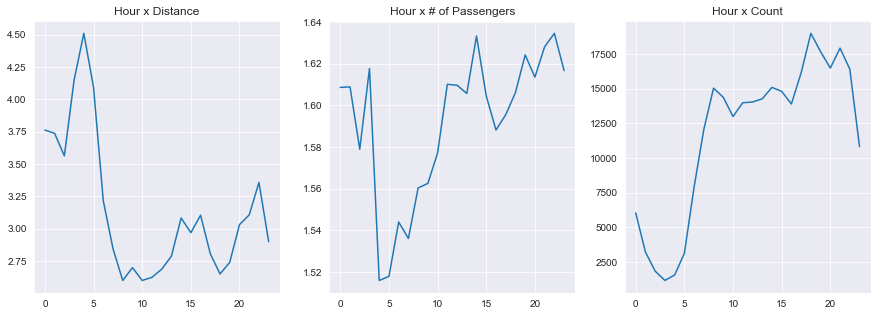

In [108]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(hourly.hour, hourly.mean_dist)
plt.title('Hour x Distance')

plt.subplot(1,3,2)
plt.plot(hourly.hour, hourly.mean_passenger)
plt.title('Hour x # of Passengers')

plt.subplot(1,3,3)
plt.plot(hourly.hour, hourly['count'])
plt.title('Hour x Count')
plt.show()